<h2><strong>Main plot</strong></h2>

In [1]:
from astropy import units as u
from astropy.coordinates import SkyCoord
from astropy.table import QTable
import astropy as a0
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.collections as mcoll
import matplotlib.path as mpath
import math
import plotly
import plotly.graph_objs as go
import plotly.express as px

from visorbits import rotations as rot
from visorbits import ellipse as consec
plotly.offline.init_notebook_mode()

<h2><strong>1. Initialize coordsiand transform to Galactocentric Cartesian system </strong></h2>
<hr>

In [2]:
c = {'Draco': {'ra': 15.*(17+20/60.+ 12.4/3600.)*u.deg, 'dec': (57+54/60.+55/3600.)*u.deg,\
                    'D':  75.8*u.kpc, 'v_r': -291.0*u.km/u.s,\
                    'mu_ra_cosd':   44.*10**(-3)*u.mas/u.yr, 'mu_dec': -188.*10**(-3)*u.mas/u.yr},\
       'Sculptor': {'ra': 15.*(1+  0/60.+  9.4/3600.)*u.deg, 'dec': (-33-42/60.-33/3600.)*u.deg,\
                    'D':  83.9*u.kpc, 'v_r':  111.4*u.km/u.s,\
                    'mu_ra_cosd':  100.*10**(-3)*u.mas/u.yr, 'mu_dec': -158.*10**(-3)*u.mas/u.yr},\
         'Fornax': {'ra': 15.*(2+ 39/60.+ 59.3/3600.)*u.deg, 'dec': (-34-26/60.-57/3600.)*u.deg, \
                    'D': 147.2*u.kpc, 'v_r':   55.3*u.km/u.s,\
                    'mu_ra_cosd':  381.*10**(-3)*u.mas/u.yr, 'mu_dec': -359.*10**(-3)*u.mas/u.yr},\
          'Leo II': {'ra': 15.*(11+13./60.+28.8/3600.)*u.deg, 'dec': (22+ 9/60.+ 6/3600.)*u.deg, \
                    'D': 233.0*u.kpc, 'v_r':   78.0*u.km/u.s,\
                    'mu_ra_cosd': -109.*10**(-3)*u.mas/u.yr, 'mu_dec': -150.*10**(-3)*u.mas/u.yr},\
           'Leo I': {'ra': 15.*(10+ 8./60.+28.1/3600.)*u.deg, 'dec': (12+18/60.+23/3600.)*u.deg,\
                    'D': 258.2*u.kpc, 'v_r':  282.5*u.km/u.s,\
                    'mu_ra_cosd':  -50.*10**(-3)*u.mas/u.yr, 'mu_dec': -120.*10**(-3)*u.mas/u.yr}}

set_of_icrs = {}

for dSph in c:
    set_of_icrs[dSph] = SkyCoord(ra=[c[dSph]['ra']], dec=[c[dSph]['dec']], distance=[c[dSph]['D']],\
                                 pm_ra_cosdec=[c[dSph]['mu_ra_cosd']], pm_dec = [c[dSph]['mu_dec']],\
                                 radial_velocity=[c[dSph]['v_r']], frame='icrs')
    
    sGC0 = set_of_icrs[dSph].transform_to(a0.coordinates.Galactocentric)

    if dSph=='Draco':
        sGC = sGC0.to_table()
        sGC = a0.table.hstack([sGC, QTable({'Name': [dSph]}, names=['Name'])])
    else:
        sGC = a0.table.vstack([sGC, a0.table.hstack([sGC0.to_table(), QTable({'Name': [dSph]}, names=['Name'])])], join_type='inner')

sGC['mass'] = np.array([11., 14., 56., 4.6, 12.]) # dynamical mass, 10^6 MSun, 10.1088/0004-6256/144/1/4; 

In [3]:
data = go.Scatter3d(x=sGC['x'], y=sGC['y'], z=sGC['z'], text = sGC['Name'], mode='markers', marker=dict(size=4), name='Dwarves')

fig = go.Figure(data)

for i, n in enumerate(sGC['Name']):
    fig.add_trace(
            go.Scatter3d(
                x=[sGC['x'][i].value, sGC['x'][i].value+sGC['v_x'][i].value],
                y=[sGC['y'][i].value, sGC['y'][i].value+sGC['v_y'][i].value],
                z=[sGC['z'][i].value, sGC['z'][i].value+sGC['v_z'][i].value],
                mode='lines', legendgroup=n,  hovertext=n,
                name="{}".format(n)  )  )

fig.update_layout(title='Figure 1.', 
                  autosize=True,
                  scene_camera_eye=dict(x=1.2, y=1.2, z=1.2),
                  scene = dict(
                    xaxis_title='X', yaxis_title='Y', zaxis_title='Z',
                    xaxis = dict(nticks=15,range=[-770,770],),
                    yaxis = dict(nticks=15,range=[-770,770],),
                    zaxis = dict(nticks=15,range=[-770,770],),),
                  width=550, height=550, template='none', scene_aspectmode='cube')
fig.show()

<h2><strong>2. Prepare <code>plotly</code> local functions </strong></h2>
<hr>
<table>
    <thead>
        <tr><th>Function</th><th>Arguments</th><th>Output</th><th>Description</th></tr>
    </thead>
    <tbody><tr><td>psurface</td>
        <td>
            <ul> 
                <li>point <em>p0</em> (3,)</li>
                <li>point <em>p1</em> (3,)</li> 
            </ul>
        </td>
        <td>
             <ul>
                 <li>Vector in the place, tau</li>
                 <li>Normal vector</li>
                 <li>X, Y of points (3,)</li>
                 <li>ZV (meshgrid of plane z-points for xiven X, Y)</li>
             </ul>
        </td>
        <td> Define our plane which contains the zero point</td></tr>
        <tr><td>rotatedset</td>
            <td>
                <ul>
                    <li><em>initial</em> (3, len(p)) set</li>
                    <li>point <em>p1</em> (3,)</li>
                    <li><em>tau_ort</em> (3,) vector which lies in the plane (perpendicular to p1 as example)</li>
                    <li><em>phi4</em> -- phase angle for final rotation</li>
                </ul>
            </td>
            <td>
                <ul>
                    <li>initial</li>
                    <li>ell1, ell2, ell3, ell4 -- steps of rotations</li>
                    <li>r1, r2, r3, r4 -- rotational matrices</li>
                </ul>
            </td>
            <td>Step-bystep rotation of <code>initil</code> dataset.</td></tr>
        <tr><td>initfig_with_surface</td>
            <td>
                <ul>
                    <li><em>x</em> -- (len(p),) array of x</li>
                    <li><em>y</em> -- (len(p),) array of y</li>
                    <li><em>zv</em> -- meshgrid array of z</li>
                </ul>
            </td>
            <td><code>fig</code> object of <code>plotly</code></td>
            <td>Initilizes <code>fig</code></td></tr>
        <tr><td>plotvectors</td>
            <td>                
                <ul>
                    <li><em>fig</em> (<code>plotly</code> object; I'm not familiar with it)</li>
                    <li><em>vectors</em> (array of pairs of (3,) points for beginning and end of each vector)</li>
                    <li><em>vc_legends</em> (list of strings for legends)</li>
                    <li><em>vc_colors</em> (list of colors)</li>
                </ul>
            </td>
            <td>--</td>
            <td>Updates <code>fig</code></td></tr>
        <tr><td>plottraces</td>
            <td>
                <ul>
                    <li><em>fig</em> (<code>plotly</code> object; I'm not familiar with it)</li>
                    <li><em>traces</em> (list of all initial and rotated lines, (len(p), 3))</li>
                    <li><em>sys_legends</em> (list of strings for legends)</li>
                    <li><em>colors</em> (list of colors)</li>
                </ul>
            </td>
            <td>--</td>
            <td>Updates <code>fig</code></td></tr>
        <tr><td>colorline</td>
            <td>
                <ul>
                    <li><em>x,y</em> coordinates of a line</li>
                    <li><em>z</em> default colors</li>
                    <li><em>cmap</em> colormap</li>
                    <li><em>norm</em> normalization of colormap</li>
                    <li><em>linewidth</em> property of the line plot</li>
                    <li><em>alpha</em> (list of colors)</li>
                </ul>
            </td>
            <td>line (a <code>LineCollection</code> object)</td>
            <td>Plots the gradient line</td></tr>
        <tr><td>make_segments</td>
            <td>
                <ul>
                    <li><em>x,y</em> coordinates of a line</li>
                </ul>
            </td>
            <td>Segments in an appropriate format for <code>LineCollection</code></td>
            <td>Prepares coordinates to pass them to colorline function</td></tr>
    </tbody>
</table>

In [4]:
def psurface(p0, p1):
    # p0 and p1 together with (0,0,0) define the plane.
    # Find the normal vector:
    norm = rot.vect_m(p0, p1)
    norm /= np.sqrt(np.sum(norm**2))
    # vtau_test is the direction of motion
    # p1 marks the location of our point (which lies on the future trace)
    vtau_test = rot.vect_m(norm, p0)
    #tau_ort  = rot.vect_m(norm_ort, r_ort)  # vtau_test
    
    tau = vtau_test/np.sqrt(np.sum(vtau_test**2))
    # Definition of the final XY plane:
    x = np.array([0, p0[0], p1[0]])
    y = np.array([0, p0[1], p1[1]])
    
    z0      = lambda xl, yl: (xl*norm[0] +yl*norm[1])*(-1)/norm[2]
    xv, yv  = np.meshgrid(x,y)
    zv      = z0(xv, yv)
    return norm, tau, x, y, zv

def rotdataset(initial, p0, tau_ort, phi4):
    # Create roational matrices 
    r1, r2, r3, r4 = rot.reverse_tr(p0[0], p0[1], p0[2], tau_ort, phi4=phi4)   
    # Application of rotational matrices, step-by-step:
    ell1 = np.dot(r1, initial.T).T
    ell2 = np.dot(r1, np.dot(r2, initial.T)).T
    ell3 = np.dot(r1, np.dot(r2, np.dot(r3, initial.T))).T
    ell4 = np.dot(np.dot(r1, np.dot(r2, np.dot(r3,r4))), initial.T).T
    return initial, ell1, ell2, ell3, ell4, r1, r2, r3, r4

def initifig_with_surface(x, y, zv):
    # Figure: vectors and 3-axes of coordinates.
    fig = go.Figure(data=[go.Surface(x=x, y=y, z=zv,\
                                     surfacecolor=np.full(zv.shape,'green'),opacity=0.2, showscale = False, name='Destination')])
    return fig

def plotvectors(fig, vectors, vc_legends, vc_colors):
    for i, v in enumerate(vectors):
        fig.add_trace(go.Scatter3d(x=[vectors[i][0][0], (vectors[i][1][0])],\
                                   y=[vectors[i][0][1], (vectors[i][1][1])],\
                                   z=[vectors[i][0][2], (vectors[i][1][2])], mode='lines',\
                                   line = dict(color=vc_colors[i]) ,line_width=3,showlegend=True,name=vc_legends[i],))
def plottraces(fig, traces, sys_legends, colors):
    for i, d in enumerate(traces):
        fig.add_trace(go.Scatter3d(x=d[:,0], y=d[:,1], z=d[:,2],\
                                   line = dict(color=colors[i]),\
                                   marker_size=1,showlegend=True,name=sys_legends[i],))

def colorline(x, y, z=None, cmap=plt.get_cmap('copper'), norm=plt.Normalize(0.0, 1.0), linewidth=3, alpha=1.0):
    """
    https://stackoverflow.com/questions/8500700/how-to-plot-a-gradient-color-line
    http://nbviewer.ipython.org/github/dpsanders/matplotlib-examples/blob/master/colorline.ipynb
    http://matplotlib.org/examples/pylab_examples/multicolored_line.html
    Plot a colored line with coordinates x and y
    Optionally specify colors in the array z
    Optionally specify a colormap, a norm function and a line width
    """
    # Default colors equally spaced on [0,1]:
    if z is None:
        z = np.linspace(0.0, 1.0, len(x))

    # Special case if a single number:
    if not hasattr(z, "__iter__"):  # to check for numerical input -- this is a hack
        z = np.array([z])

    z = np.asarray(z)

    segments = make_segments(x, y)
    lc = mcoll.LineCollection(segments, array=z, cmap=cmap, norm=norm,
                              linewidth=linewidth, alpha=alpha)

    ax = plt.gca()
    ax.add_collection(lc)

    return lc

def make_segments(x, y):
    """
    Create list of line segments from x and y coordinates, in the correct format
    for LineCollection: an array of the form numlines x (points per line) x 2 (x
    and y) array
    """
    points = np.array([x, y]).T.reshape(-1, 1, 2)
    segments = np.concatenate([points[:-1], points[1:]], axis=1)
    return segments

<blockquote>
    <p><h3>3.1 Plot all steps</h3></p>
<blockquote>

In [5]:
s = sGC

ellipses = {}
for key in list(sGC['Name']):
    ellipses[key] = {'x': [], 'y': [], 'z': [], 'set': [], 'xc': [], 'yc': [], 'zc': [], 'setc': [], 'angle': [], 'anglex': []}

for i00, n in enumerate(sGC['Name']):
    
    r_dwarf = np.array([sGC['x'][i00].value, sGC['y'][i00].value, sGC['z'][i00].value])
    v_dwarf = np.array([sGC['v_x'][i00].value, sGC['v_y'][i00].value, sGC['v_z'][i00].value])
    
    r0 = np.sum(r_dwarf**2)**0.5;
    v0 = np.sum(v_dwarf**2)**0.5

    norm_ort, tau_ort, x, y, zv =  psurface(r_dwarf, v_dwarf)
    
    vt = np.sum(tau_ort * v_dwarf)*tau_ort
    vt0 = np.sqrt(np.sum(vt**2))
    
    e = consec.ecc(r0*u.kpc, v0*u.km/u.s, vt0*u.km/u.s)
    a = consec.a_ax(r0*u.kpc, v0*u.km/u.s)
    
    psi_current = consec.angl_ecc(r0, e, a, np.sum(r_dwarf*v_dwarf)/abs(np.sum(r_dwarf*v_dwarf)))
    while abs(psi_current)>2*np.pi or psi_current<0:
        psi_current +=2*np.pi*(-1*psi_current)/(abs(psi_current))
    
    phi4 = consec.angl_c(psi_current, e)
    while abs(phi4)>2*np.pi or phi4<0:
        phi4 +=2*np.pi*(-1*phi4)/(abs(phi4))
    # Definition of the orbit in its own space:
    # r_dwarf - is our curent point with phi4 phase angle from pericenter
    ang     = np.linspace(0, np.pi*2, 1000);
    xcircle = a*(1-e**2)/(1+e*np.cos(ang))*np.cos(ang)
    ycircle = a*(1-e**2)/(1+e*np.cos(ang))*np.sin(ang)
    zcircle = np.zeros(len(ang))
    points1 = np.hstack([np.reshape(xcircle, (len(xcircle), 1)), np.reshape(ycircle, (len(xcircle), 1))])
    initial = np.hstack([points1, np.reshape(zcircle, (len(xcircle), 1))])
    
    cut = np.where([((ang<=phi4)&(ang>=phi4*0.6))])[1]
    points_partial = np.hstack([np.reshape(xcircle[cut], (len(xcircle[cut]), 1)), np.reshape(ycircle[cut], (len(xcircle[cut]), 1))])
    initial_cut = np.hstack([points_partial, np.reshape(zcircle[cut], (len(xcircle[cut]), 1))])

    p1 = np.array([xcircle[0], ycircle[0], zcircle[0]])
    p2 = np.array([a*(1-e**2)/(1+e*np.cos(phi4))*np.cos(phi4),\
                  a*(1-e**2)/(1+e*np.cos(phi4))*np.sin(phi4), 0.])
    
    # Create roational matrices 
    initial, ell1, ell2, ell3, ell4, r1, r2, r3, r4 = rotdataset(initial, r_dwarf, v_dwarf, phi4=phi4)
    initialc, ell1c, ell2c, ell3c, ell4c, r1c, r2c, r3c, r4c = rotdataset(initial_cut, r_dwarf, v_dwarf, phi4=phi4)

    ellipses[n]['x'] = ell4[:,0];   ellipses[n]['y'] = ell4[:,1];  ellipses[n]['z'] = ell4[:,2]; ellipses[n]['set'] = ell4
    ellipses[n]['xc'] = ell4c[:,0]; ellipses[n]['yc'] = ell4c[:,1]; ellipses[n]['zc'] = ell4c[:,2]; ellipses[n]['setc'] = ell4c
    ellipses[n]['anglec'] = ang[cut]
    ellipses[n]['angle'] = ang

    p1 = np.dot(np.dot(r1, np.dot(r2, np.dot(r3,r4))), p1)
    p2 = np.dot(np.dot(r1, np.dot(r2, np.dot(r3,r4))), p2)

    fig2 = go.Figure()
    
    # Prepare settings for vectors' plot:
    vectors    = np.array([[np.zeros(3,), norm_ort*a], [np.zeros(3,), r_dwarf], [r_dwarf, r_dwarf+v_dwarf],\
                           [np.zeros(3,), p1], [np.zeros(3,), tau_ort*a]])
    vc_legends = ['Normal', 'Rad-vector of the point which belongs to the final ellipse (x3)',\
                  f'Velocity direction, phase angle is {phi4*180./np.pi}', 'Pericenter', 'The Dwarf']
    vc_colors  = ['pink', 'orange', 'cyan', 'black', 'red']
    
    # Prepare settings for lines' plot:
    traces = list([initial, ell1, ell2, ell3, ell4])
    ell_legends = ['Initial', 'Aligned with XY-projection of point, which belongs to final',\
                   'Final X is he point radius-vector', 'XY is in the correct plane', 'Correct phase: X is in the pericenter']
    colors      = ['black', 'red', 'orange', 'lime', 'cyan']

    plotvectors(fig2, vectors, vc_legends, vc_colors)
    plottraces(fig2, traces, ell_legends, colors)
    
    fig2.update_layout(title=f'Figure {4+i00}. {n}', autosize=True,
                      scene_camera_eye=dict(x=1.2, y=1.2, z=1.2),
                      scene = dict(xaxis_title='X', yaxis_title='Y', zaxis_title='Z',\
                                   xaxis = dict(nticks=5), yaxis = dict(nticks=5), zaxis = dict(nticks=5),),\
                      width=1000, height=700, template='none', scene_aspectmode='data')
    
    fig2.show()

<blockquote>
    <p><h3>3.2 The set of orbits:</h3></p>
<blockquote>

In [6]:
fig3 = go.Figure()
colors_dwarfc = ['red', 'orange', 'green', 'blue', 'purple']

for i, n in enumerate(list(sGC['Name'])):
    d = ellipses[n]['set']
    dc = ellipses[n]['setc']
    plottraces(fig3, list([d]), [n], ['grey'])
    plottraces(fig3, list([dc]), [n], [colors_dwarfc[i]])
    fig3.add_trace(
            go.Scatter3d(
                x=[sGC['x'][i].value, sGC['x'][i].value+sGC['v_x'][i].value],
                y=[sGC['y'][i].value, sGC['y'][i].value+sGC['v_y'][i].value],
                z=[sGC['z'][i].value, sGC['z'][i].value+sGC['v_z'][i].value],
                mode='lines', legendgroup=n,  hovertext=n, line=dict(color=colors_dwarfc[i]),
                name="{} position".format(n)  )  )

fig3.update_layout(title='Figure..', autosize=True,
                  scene_camera_eye=dict(x=1.2, y=1.2, z=1.2),
                  scene = dict(xaxis_title='X', yaxis_title='Y', zaxis_title='Z',\
                               xaxis = dict(nticks=5), yaxis = dict(nticks=5), zaxis = dict(nticks=5),),\
                  width=1000, height=700, template='none', scene_aspectmode='data')
fig3.show()

<h2>4. Projection</h2>

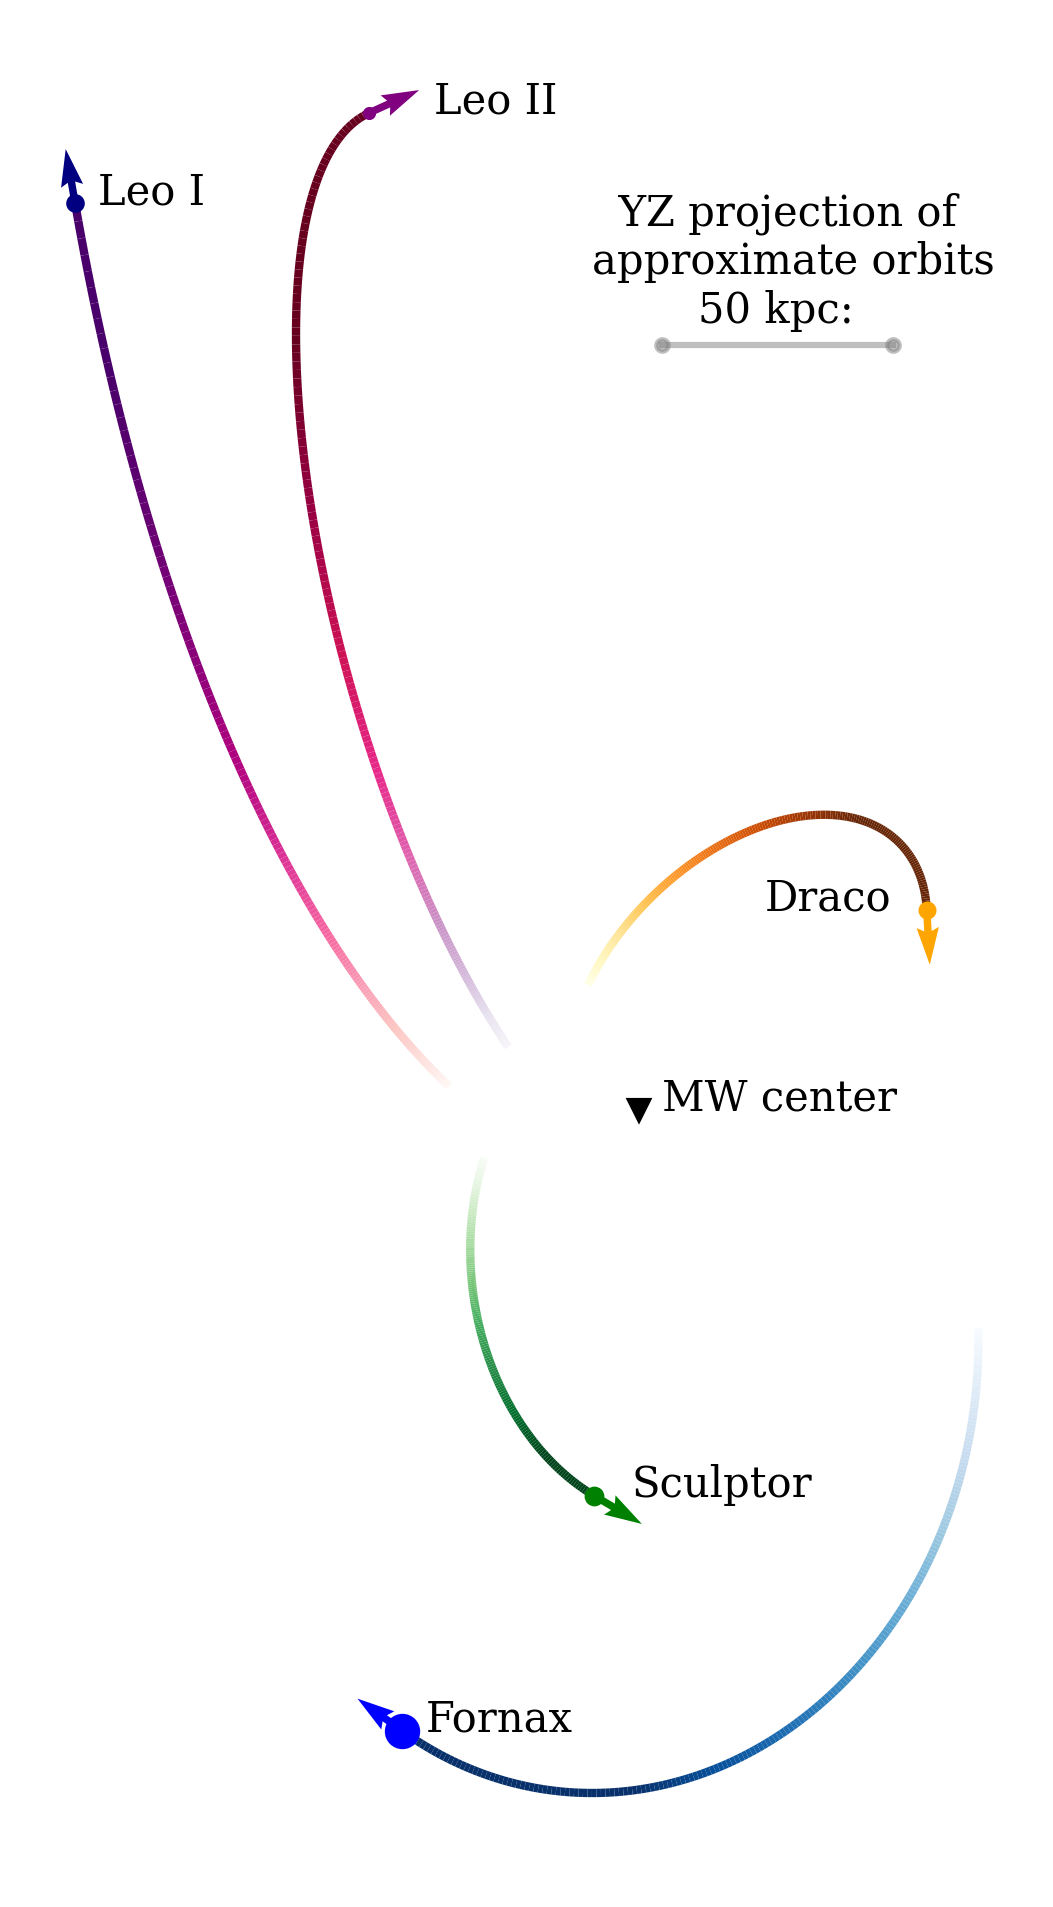

In [8]:
colors_dwarfc = ['orange', 'green', 'blue', 'purple', 'navy']
color_maps = ['YlOrBr', 'Greens', 'Blues', 'PuRd', 'RdPu']
shift = [-35,8,5,14,5]
fig = plt.figure(figsize=(5,8), dpi=300)
ax = fig.add_subplot(111)
plt.rcParams['font.family'] = 'DeJavu Serif'
plt.rcParams['font.serif' ] = ['Times New Roman']

for i, n in enumerate(list(sGC['Name'])):
    
    dc = ellipses[n]['setc']
    dist = np.sqrt((dc[:,1]-dc[:,1][-1])**2+(dc[:,2]-dc[:,2][-1])**2)
    colorline(dc[:,1], dc[:,2], ellipses[n]['anglec']-ellipses[n]['anglec'][0], cmap=plt.get_cmap(color_maps[i]), linewidth=2)
    U, V = np.meshgrid([sGC['v_y'][i].value], [sGC['v_z'][i].value])
    ax.quiver(sGC['y'][i].value, sGC['z'][i].value, U*3, V*3, color=colors_dwarfc[i],\
              linewidth=1.2)
    #ax.plot(dc[:, 1], dc[:, 2], marker='.', color = colors_dwarfc[i])
    
    ax.plot([sGC['y'][i].value],  [sGC['z'][i].value],\
            color=colors_dwarfc[i], label="{}".format(n), marker='o',markersize=sGC['mass'][i]**0.5)
    ax.text(x=sGC['y'][i].value+shift[i],  y=sGC['z'][i].value, s=n)

ax.tick_params(which='both', direction="in", labelbottom=False, labeltop=False,\
                    labelleft=False, labelright=False, bottom=False, top=False, left=False, right = False)
#ax.set_xlabel('Y, kpc')
#ax.set_ylabel('Z, kpc')
ax.plot(0, 0, marker='v', markersize=5, color='k')
ax.plot([5, 55], [165, 165], marker='.', linestyle='solid', color='grey', alpha=0.5)
ax.text(0+5,0, s='MW center')
ax.text(-10, 170, s='  YZ projection of\napproximate orbits\n        50 kpc:')
ax.set_aspect('equal', adjustable='box')
ax.set_frame_on(False)
plt.savefig(f'illustration.jpg', format='jpg', bbox_inches='tight', pad_inches=0)
plt.savefig(f'illustration.pdf', format='png', bbox_inches='tight', pad_inches=0)